In [1]:
file_path = "/content/Cit-HepTh.txt"

with open(file_path, "r") as file:
    for _ in range(10):
        print(file.readline().strip())


# Directed graph (each unordered pair of nodes is saved once): Cit-HepTh.txt
# Paper citation network of Arxiv High Energy Physics Theory category
# Nodes: 27770 Edges: 352807
# FromNodeId	ToNodeId
1001	9304045
1001	9308122
1001	9309097
1001	9311042
1001	9401139
1001	9404151


In [22]:
import tarfile

with tarfile.open("/content/cit-HepTh-abstracts.tar.gz", "r:gz") as tar:
    tar.extractall(path="/content/cit-HepTh-abstracts")

print(" Abstracts extracted.")




 Abstracts extracted.


In [26]:
import re
from pathlib import Path
import pandas as pd


base_path = Path("/content/cit-HepTh-abstracts")
metadata_records = []

# mapping function for field classification
def map_to_field(raw_text):
    raw_text = raw_text.lower()
    if "phenomenology" in raw_text:
        return "hep-ph"
    elif "experiment" in raw_text:
        return "hep-ex"
    elif "lattice" in raw_text:
        return "hep-lat"
    elif "quantum algebra" in raw_text or "mathematical physics" in raw_text:
        return "hep-th"
    elif any(term in raw_text for term in ["chaotic dynamics", "superconductivity", "quantum hall", "mesoscopic", "statistical mechanics"]):
        return "cond-mat"
    elif any(term in raw_text for term in ["algebraic geometry", "differential geometry", "symplectic", "functional analysis"]):
        return "math-ph"
    elif "theory" in raw_text:
        return "hep-th"
    else:
        return "other"

# Iterate through all files
for year_folder in base_path.iterdir():
    if year_folder.is_dir():
        for file in year_folder.glob("*.abs"):
            try:
                with open(file, "r", encoding="utf-8", errors="ignore") as f:
                    lines = f.readlines()
                paper_id = int(file.stem)
                field_line = next((line for line in lines if "Subj-class:" in line), None)
                if field_line:
                    raw_subject = field_line.replace("Subj-class:", "").strip()
                    field = map_to_field(raw_subject)
                    metadata_records.append({"paper_id": paper_id, "field": field})
            except Exception as e:
                print(f"Error reading {file.name}: {e}")


metadata_df = pd.DataFrame(metadata_records)
metadata_df.to_csv("/content/metadata.csv", index=False)
metadata_df['field'].value_counts(), metadata_df.head()


(field
 hep-th      1900
 math-ph      439
 cond-mat     204
 Name: count, dtype: int64,
    paper_id    field
 0    205126  math-ph
 1    211213  math-ph
 2    212042   hep-th
 3    210188   hep-th
 4    210143   hep-th)

In [27]:
# Clean up
metadata_df["field"] = metadata_df["field"].str.strip().str.replace(r"[^\w\-]+", "", regex=True)


metadata_df.to_csv("/content/metadata.csv", index=False)

metadata_df['field'].value_counts()


,count
field,
hep-th,1900
math-ph,439
cond-mat,204


In [31]:
import gzip

#Load the submission dates file
with gzip.open("/content/cit-HepTh-dates.txt.gz", 'rt') as f:
    time_df = pd.read_csv(f, sep='\t', header=None, names=["paper_id", "date"])

# Remove comments and clean paper IDs
time_df = time_df[~time_df['paper_id'].astype(str).str.startswith('#')].copy()
time_df['paper_id'] = time_df['paper_id'].astype(int)
time_df['date'] = pd.to_datetime(time_df['date'])

# Load your metadata (fields per paper)
metadata = pd.read_csv("/content/metadata.csv")  # Update path if needed

# Merge metadata with dates
merged_df = pd.merge(metadata, time_df, on="paper_id", how="inner")

# Add 'year' column
merged_df['year'] = merged_df['date'].dt.year

# save
merged_df.to_csv("/content/metadata_with_dates.csv", index=False)


print(" metadata_with_dates.csv created.")
merged_df.head()


✅ metadata_with_dates.csv created.


,paper_id,field,date,year
0,201080,hep-th,2002-01-10,2002
1,202110,hep-th,2002-02-12,2002
2,201156,hep-th,2002-01-17,2002
3,203072,cond-mat,2002-03-07,2002
4,201045,hep-th,2002-01-08,2002


In [15]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

 Number of Papers (Nodes): 27770
 Number of Citations (Edges): 352807

 COIN Matrix (Citation Flow Between Fields):
          cond-mat  hep-th  math-ph
cond-mat       125     122        7
hep-th          93    2862      362
math-ph          0     187      833
 Introspection for cond-mat: 0.4921
 Introspection for hep-th: 0.8628
 Introspection for math-ph: 0.8167
 Export-Import Ratio for cond-mat: 1.3871
 Export-Import Ratio for hep-th: 1.4725
 Export-Import Ratio for math-ph: 0.5068


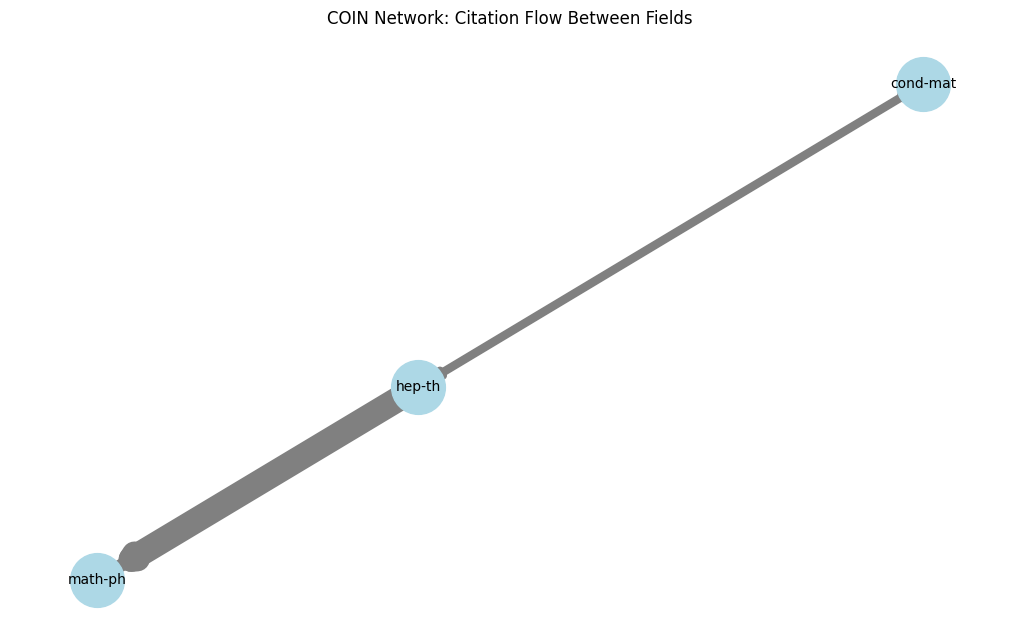

In [32]:
# load data
file_path = "/content/Cit-HepTh.txt"

edges = []
with open(file_path, "r") as f:
    for line in f:
        if line.startswith("#"):
            continue
        source, target = map(int, line.strip().split())
        edges.append((source, target))

G = nx.DiGraph()
G.add_edges_from(edges)

print(f" Number of Papers (Nodes): {G.number_of_nodes()}")
print(f" Number of Citations (Edges): {G.number_of_edges()}")

# Load Metadata and Assign Fields
metadata = pd.read_csv("metadata.csv")
paper_field_map = dict(zip(metadata["paper_id"], metadata["field"]))
nx.set_node_attributes(G, paper_field_map, "field")

#  COIN Matrix
fields = sorted(metadata["field"].unique())
field_indices = {field: idx for idx, field in enumerate(fields)}
n = len(fields)
coin_matrix = np.zeros((n, n), dtype=int)

for u, v in G.edges():
    field_u = G.nodes[u].get("field")
    field_v = G.nodes[v].get("field")
    if field_u and field_v:
        i, j = field_indices[field_u], field_indices[field_v]
        coin_matrix[i, j] += 1

coin_df = pd.DataFrame(coin_matrix, index=fields, columns=fields)
print("\n COIN Matrix (Citation Flow Between Fields):")
print(coin_df)

# Computing Self-Citation Ratio (Introspection) per Field
introspection_scores = {}
for field in fields:
    i = field_indices[field]
    self_cites = coin_matrix[i, i]
    total_cites = np.sum(coin_matrix[i, :])
    ratio = self_cites / total_cites if total_cites > 0 else 0
    print(f" Introspection for {field}: {ratio:.4f}")

# Export-Import Ratio per Field
export_import_scores = {}
for field in fields:
    i = field_indices[field]
    exports = np.sum(coin_matrix[i, :]) - coin_matrix[i, i]
    imports = np.sum(coin_matrix[:, i]) - coin_matrix[i, i]
    ratio = exports / imports if imports > 0 else float('inf')
    print(f" Export-Import Ratio for {field}: {ratio:.4f}")

# Visualize the COIN Network
H = nx.DiGraph()
for i, f_from in enumerate(fields):
    for j, f_to in enumerate(fields):
        if coin_matrix[i, j] > 0 and f_from != f_to:
            H.add_edge(f_from, f_to, weight=coin_matrix[i, j])

pos = nx.spring_layout(H, seed=42)
plt.figure(figsize=(10, 6))
edges, weights = zip(*nx.get_edge_attributes(H, 'weight').items())
nx.draw(H, pos, with_labels=True, node_size=1500, node_color="lightblue", font_size=10, arrows=True)
nx.draw_networkx_edges(H, pos, edge_color='gray', width=[w/20 for w in weights])
plt.title("COIN Network: Citation Flow Between Fields")
plt.show()


In [23]:
import os
os.listdir("/content")


['.config',
 'cit-HepTh-abstracts',
 'cit-HepTh-abstracts.tar.gz',
 'Cit-HepTh.txt',
 'metadata.csv',
 'sample_data']

In [24]:
import os


[entry for entry in os.listdir("/content") if "hep" in entry.lower()]


['cit-HepTh-abstracts', 'cit-HepTh-abstracts.tar.gz', 'Cit-HepTh.txt']